<div dir="rtl">

# تحليل بيانات WaPOR
    
</div>

<div dir="rtl">
يحتوي هذا الدفتر على مثال رمز لتحليل بيانات WaPOR ، بما في ذلك:    
</div>

<div dir="rtl">
    
- [1. احسب متوسط قيمة العائد على الاستثمار](#1.-Calculate-the-average-value-of-ROI)
- [2. العمل مع السلاسل الزمنية (مكتبة pandas)](#2.-Working-with-timeseries-(pandas-library))
- [3. حساب النقطية](#3.-Raster-calculation)
- [4. تحليل استخدامات الأراضي](#4.-Land-use-analysis)    
    
</div>

<div dir="rtl">
بعد الأمثلة، سيكون هناك بعض تمارين الترميز لممارستها    
</div>

<div dir="rtl">

### استيراد مكتبات ووظائف  
    
</div>

<div dir="rtl">
في هذا التمرين، يمكننا الاستفادة من الوظائف المعرفة من قبل المستخدم التي قمنا بها في التمرين السابق للقراءة ويمكن كتابة البيانات النقطية    
</div>

In [1]:
import numpy as np
import gdal
import osr
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ogr
import datetime

def GetGeoInfo(fh, subdataset = 0):
    """
    بيانات وصفية مجردة من ملف جغرافي أو HDF4 أو netCDF.
    
    المعلمات
    ----------
    fh : str
        التعامل مع الملف ليتم فحصه.
    subdataset : int, اختياري
        الطبقة التي سيتم استخدامها في حالة تنسيق HDF4 أو netCDF ، الافتراضي هو 0.
        
    عائدات
    -------
    driver : str
        قرص  fh.
    NDV : float
        لا توجد بيانات-قيمة fh.
    xsize : int
        مقدار البكسل في الاتجاه س.
    ysize : int
        مقدار البكسل في اتجاه ص.
    GeoT : list
        قائمة بقيم التحويل الجغرافي
    Projection : str
       إسقاط fh.
    """
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    """
    افتح الخريطة كمصفوفة متفرقة
    
    العائدات
    ----------
    fh: str
        مقبض الملف للتعيين للفتح.
    bandnumber : int, اختياري 
        النطاق أو الطبقة المراد فتحها كمصفوفة ، الافتراضي هو 1.
    dtype : str, اختياري
        نوع البيانات لنسق الإخراج ، الافتراضي هو "float32".
    nan_values : boolean, اختياري
    قم بتحويل قيم عدم وجود بيانات إلى قيم np.nan ، لاحظ أن نوع dtype يحتاج إلى
    يكون afloat إذا كان هذا صحيحًا. Default هو خطأ
        
    العائدات
    -------
    Array : ndarray
        مجموعة مع القيم بكسل.
    """
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16,
                 "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
                 "int32": np.int32, "float32": np.float32, "float64": np.float64, 
                 "complex64": np.complex64, "complex128": np.complex128,
                "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, 
                 "Complex64": np.complex64, "Complex128": np.complex128,}
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, Projection, explicit = True, compress = None):
    """
    ينشئ GeoTIFF من مصفوفة عددية.
    
    المعلمات
    ----------
    fh : str
        معالجة الملفات للإخراج
    Array: ndarray
        مجموعة لتحويل لملفات GeoTiff
    driver : str
        قرص fh.
    NDV : float
        لا توجد بيانات-قيمة fh.
    xsize : int
        مقدار البكسل في الاتجاه س
    ysize : int
        مقدار البكسل في اتجاه ص
    GeoT : list
        قائمة بقيم التحويل الجغرافي.
    Projection : str
        إسقاط fh.    
    """
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan


def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    يطابق الإسقاط والقرار وقيمة عدم وجود بيانات لقائمة ملفات الهدف مع ملف المصدر ويحفظ الخرائط الجديدة في output_dir.
    
    العائدات
    ----------
    source_file : str
        الملف المراد مطابقة الإسقاط والقرار و ndv به.
    target_fhs : list
        الملفات المراد إعادة إسقاطها.
    output_dir : str
        مجلد لتخزين الإخراج.
    resample : str, optional
        طريقة إعادة التشكيل المراد استخدامها ، الافتراضي هو "قريب" (أقرب جار).
    dtype : str, optional
        نوع بيانات الإخراج ، الافتراضي هو "float32".
    scale : int, optional
        تعدد كل الخرائط بهذه القيمة ، الافتراضي هو بلا
    
    Returns
    -------
    output_files : ndarray 
        مقابض الملفات للملفات التي تم إنشاؤها.
    """
    dst_info=gdal.Info(gdal.Open(source_file),format='json')
    output_files = np.array([])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for target_file in target_fhs:
        folder, fn = os.path.split(target_file)
        src_info=gdal.Info(gdal.Open(target_file),format='json')
        output_file = os.path.join(output_dir, fn)
        gdal.Warp(output_file,target_file,format='GTiff',
                      srcSRS=src_info['coordinateSystem']['wkt'],
                      dstSRS=dst_info['coordinateSystem']['wkt'],
                      srcNodata=src_info['bands'][0]['noDataValue'],
                      dstNodata=dst_info['bands'][0]['noDataValue'],
                      width=dst_info['size'][0],
                      height=dst_info['size'][1],
                      outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                    dst_info['cornerCoordinates']['lowerLeft'][1],
                                    dst_info['cornerCoordinates']['upperRight'][0],
                                    dst_info['cornerCoordinates']['upperRight'][1]),
                      outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                      resampleAlg=resample)
        output_files = np.append(output_files, output_file)
        if not np.any([scale == 1.0, scale == None, scale == 1]):
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = True) * scale
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
        if ndv_to_zero:
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = False)
            DATA[DATA == NDV] = 0.0
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_files

def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    قص النقطية إلى خط الحدود لملف الشكل
    
    المعلمات
    ----------
    input_fhs : list
        قائمة ملفات الإدخال النقطية
    output_folder : str
        المسار إلى المجلد حيث يتم حفظ البيانات النقطية للإخراج
    shp_fh : str
        مجلد لتخزين المخرجات
    NDV : float or int, optional
        لا توجد قيمة بيانات للمخرجات النقطية
        
    العائدات
    -------
    output_fhs : list 
        مقابض الملفات للملفات التي تم إنشاؤها.
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )
    output_fhs=[]
    for input_fh in input_fhs:
        output_fh=os.path.join(output_folder,os.path.basename(input_fh))
        sourceds = gdal.Warp(output_fh, input_fh, options = options)
        output_fhs.append(output_fh)
    return output_fhs

## 1. Calculate the average value of ROI   

<div dir="rtl">
1. حسب متوسط قيمة العائد على الاستثمار
</div>

<div dir="rtl">

### مثال
    
</div>

<div dir="rtl">

احسب متوسط هطول الأمطار في منطقة الاهتمام (ROI) من خريطة نقطية (مم / شهر). ET_folder و P_folder هما المساران المؤديان إلى مجلد البخرنتح الفعلي والاعتراض والهطول الذي تم تنزيله من التمرين في دفتر الملاحظات 3 تنزيلات مجمعة لبيانات WaPOR (3_Bulk_download_WaPOR_data.ipynb). إذا تم تنزيل الملفات بنجاح، فسيكون عدد الملفات في المجلدين 24 لكل ملف. 
    
</div>

[3 Bulk download WaPOR data](3_Bulk_download_WaPOR_data.ipynb)

In [2]:
# حدد مجلد ET و P.
ET_folder=r".\data\WAPOR.v2_monthly_L1_AETI_M"
P_folder=r".\data\WAPOR.v2_monthly_L1_PCP_M"
# احصل على قائمة الملفات في المجلد
P_fhs=sorted(glob.glob(os.path.join(P_folder,'*.tif')))
ET_fhs=sorted(glob.glob(os.path.join(ET_folder,'*.tif')))
print('عدد الملفات في {0}: {1}'.format(P_folder,len(P_fhs)))
print('عدد الملفات في {0}: {1}'.format(ET_folder,len(ET_fhs)))

Number of files in .\data\WAPOR.v2_monthly_L1_PCP_M: 24
Number of files in .\data\WAPOR.v2_monthly_L1_AETI_M: 24


<div dir="rtl">
أولاً ، تحقق مما إذا كانت خريطة هطول الأمطار مشوهة بنفس الحجم مع خريطة AETI لعائد الاستثمار    
</div>

(111, 128)
(2461, 2851)


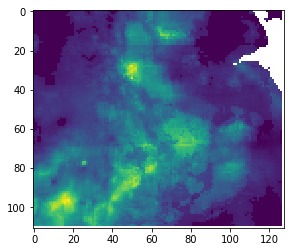

In [3]:
# احصل على مسار الملف الأول:
P_fh=P_fhs[0]
ET_fh=ET_fhs[0]
# افتح الملفات كمصفوفة
P=OpenAsArray(P_fh,nan_values=True)
ET=OpenAsArray(ET_fh,nan_values=True)
# طباعة شكل المصفوفات
print(P.shape)
print(ET.shape)

plt.imshow(P)
plt.show()

<div dir="rtl">
يختلف حجم صفيفتي ET و P لأن دقة المستوى 1 لهطول الأمطار يبلغ 5 كيلومترات و ET يبلغ 250 مترًا. لعمل التواء لجميع البيانات النقطية لهطول الأمطار بنفس الدقة باستخدام البيانات النقطية لتصنيف الغطاء الأرضي ، استخدم الوظيفة المحددة MatchProjResNDV    
</div>

In [4]:
output_folder=r'.\data\WAPOR.v2_monthly_L1_PCP_M_warped'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
P_fhs=MatchProjResNDV(ET_fh, P_fhs, output_folder)

<div dir="rtl">
بعد ذلك ، سنقوم بقص البيانات النقطية ET و P إلى المنطقة محل الاهتمام باستخدام حد الحوض في ملف الأشكال ".\data\Awash Shapefile.shp"    
</div>

In [5]:
shp_fh=r".\data\Awash_shapefile.shp"
ET_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M_clipped' # مجلد جديد ET
P_folder=r'.\data\WAPOR.v2_monthly_L1_PCP_M_clipped' # مجلد P جديد
if not os.path.exists(ET_folder):
    os.makedirs(ET_folder) # إنشاء مجلد ET جديد
if not os.path.exists(P_folder):
    os.makedirs(P_folder) # إنشاء مجلد P جديد
ET_fhs=CliptoShp(ET_fhs,ET_folder,shp_fh) # قص كل P النقطية لملف الشكل
P_fhs=CliptoShp(P_fhs,P_folder,shp_fh) # قص جميع البيانات النقطية إلى ملف الشكل

<div dir="rtl">
وبالتالي ، يمكننا الحصول على متوسط هطول الأمطار للمنطقة بأكملها بواسطة numpy.nanmean مما يعني حساب المتوسط باستثناء وحدات البكسل بقيم nan    
</div>

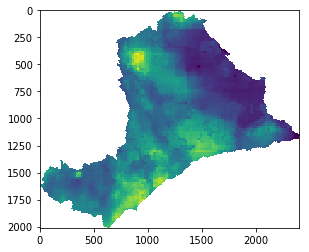

Average Precipitation (mm/month): 25.643678665161133


In [6]:
P=OpenAsArray(P_fhs[0],nan_values=True)
plt.imshow(P)
plt.show()
Average_P=np.nanmean(P)
print('متوسط هطول الأمطار (mm/month): {0}'.format(Average_P))

<div dir="rtl">
للحصول على قيم جميع خرائط هطول الأمطار الشهرية (P) وحفظ القيمة في قائمة Python ورسم متوسط هطول الأمطار مقابل الوقت ، سنقوم بتكرار جميع البيانات النقطية الشهرية وحساب متوسط P والتاريخ. يمكننا الاستفادة من اسم الملف للحصول على فهرس التاريخ والوقت. انظر إلى المثال أدناه.    
</div>

In [7]:
dates=[] 
months=[]
years=[]
P_values=[]
for P_fh in P_fhs:
    filename=os.path.basename(P_fh) # الحصول على اسم الملف من سلسلة معالج الملفات
    datestr=filename.split('.')[0].split('_')[-1] # الحصول على سلسلة التاريخ من اسم الملف
    dyear=int('20'+datestr[0:2]) # الحصول على رقم السنة من سلسلة التاريخ
    dmonth=int(datestr[2:4]) # الحصول على رقم الشهر من سلسلة التاريخ
    dates.append(datetime.date(dyear,dmonth,1)) # إنشاء عنصر التاريخ والوقت من رقم السنة والشهر
    months.append(dmonth) # إلحاق بقائمة الأشهر
    years.append(dyear) # إلحاق قائمة السنوات
    # احسب القيمة
    P=OpenAsArray(P_fh,nan_values=True) # النقطية المفتوحة كمصفوفة معقدة
    Average_P=np.nanmean(P) # حساب متوسط P
    P_values.append(Average_P)    # إلحاق بقائمة P_values

<div dir="rtl">
بعد استخراج متوسط القيمة الشهرية للخطوط النقطية ، يمكننا رسم قيم P_values لمعرفة النتائج    
</div>

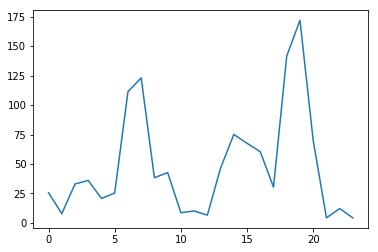

In [8]:
plt.plot(P_values)
plt.show()

<div dir="rtl">
يمكننا تزيين الرسم البياني الخاص بنا ببعض التعليمات البرمجية الإضافية. على سبيل المثال ، قم بتشغيل الكود أدناه وانظر الرسم البياني الناتج. يمكنك محاولة تخصيص الرسم البياني    
</div>

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


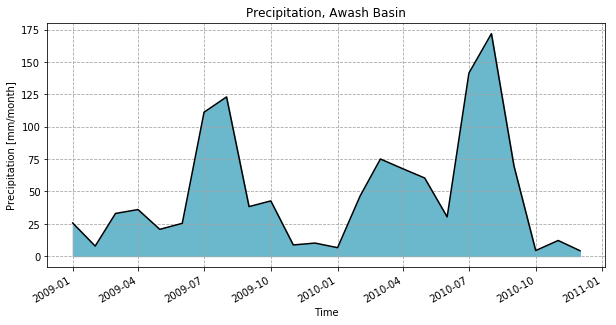

In [9]:
output_dir=r'.\data'
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) # إضافة خط الشبكة
ax = plt.subplot(111)
ax.plot(dates, P_values, '-k') #ارسم البيانات كخط أسود
ax.fill_between(dates, P_values, color = '#6bb8cc') # ملء منطقة الخط باللون الأزرق
ax.set_xlabel('Time') # إضافة عنوان المحور س
ax.set_ylabel('Precipitation [mm/month]') # أضف عنوان المحور ص
ax.set_title('Precipitation, Awash Basin') # إضافة عنوان الشكل
fig.autofmt_xdate() # محور تواريخ التنسيق التلقائي
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_ts.png')) # حفظ الرقم للإخراج
plt.show()

## 2. Working with timeseries (pandas library)

<div dir="rtl">
2. العمل مع Timeseries (مكتبة pandas )    
</div>

<div dir="rtl">

### مثال    
    
</div>


<div dir="rtl">
يمكن دمج القوائم التي تم إنشاؤها (التواريخ ، الأشهر ، السنوات ، P_values) في كائن DataFrame باستخدام pandas.DataFrame. تجعل هذه البنية تنظيف البيانات وتحويلها ومعالجتها وتحليلها أسهل. على سبيل المثال ، يُنشئ الكود أدناه DataFrame من قائمة التواريخ ومتوسط قيم الهطول    
</div>

In [10]:
P_df=pd.DataFrame({'date':dates,'month':months,'year':years,'value': P_values})
P_df

date  month  year       value
0   2009-01-01      1  2009   25.643679
1   2009-02-01      2  2009    7.820275
2   2009-03-01      3  2009   33.018497
3   2009-04-01      4  2009   36.029739
4   2009-05-01      5  2009   20.754398
5   2009-06-01      6  2009   25.401539
6   2009-07-01      7  2009  111.232544
7   2009-08-01      8  2009  123.038208
8   2009-09-01      9  2009   38.304550
9   2009-10-01     10  2009   42.717953
10  2009-11-01     11  2009    8.698319
11  2009-12-01     12  2009   10.138801
12  2010-01-01      1  2010    6.586569
13  2010-02-01      2  2010   46.456440
14  2010-03-01      3  2010   75.082008
15  2010-04-01      4  2010   67.536217
16  2010-05-01      5  2010   60.426426
17  2010-06-01      6  2010   30.349817
18  2010-07-01      7  2010  141.499390
19  2010-08-01      8  2010  171.910889
20  2010-09-01      9  2010   69.839439
21  2010-10-01     10  2010    4.362825
22  2010-11-01     11  2010   12.142183
23  2010-12-01     12  2010    4.248259

<div dir="rtl">
على سبيل المثال ، يمكننا بسهولة تلخيص هطول الأمطار للقيم الشهرية في إجمالي هطول الأمطار السنوي باستخدام groupby من عام العمود مع مجموع الطريقة.    
</div>

In [11]:
Year_total=P_df.groupby(['year']).sum()
Year_total['value']

year
2009    482.798503
2010    690.440463
Name: value, dtype: float64

<div dir="rtl">
يمكن تحويل أعمدة DataFrame إلى مصفوفة ورسمها بسهولة. يوجد أدناه رمز لتخطيط إجمالي هطول الأمطار السنوي.    
</div>

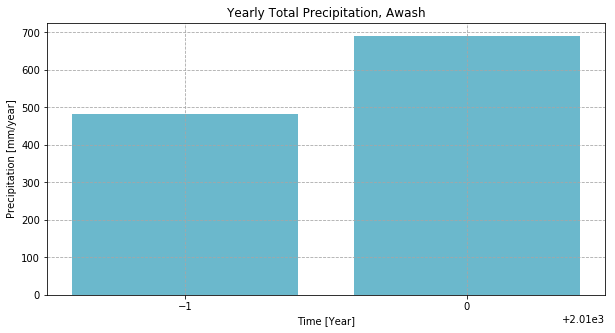

In [12]:
fig = plt.figure(figsize = (10,5))
ax2 = plt.subplot(111)
ax2.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax2.bar(Year_total.index, Year_total['value'].values, 0.8, color = '#6bb8cc')
ax2.set_xlabel('Time [Year]')
ax2.set_xticks(Year_total.index)
ax2.set_ylabel('Precipitation [mm/year]')
ax2.set_title('Yearly Total Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_year.png'))
plt.show()
plt.close(fig)

<div dir="rtl">
لحساب متوسط هطول الأشهر التقويمية ورسمها ، يمكننا التجميع حسب الطريقة ، واستخدام المتوسط بدلاً من المجموع:    
</div>
P_df.groupby(['month']).mean()

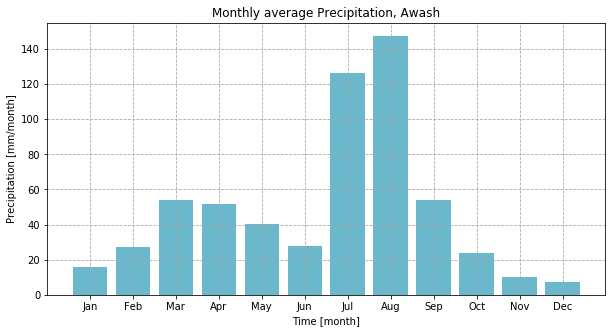

In [13]:
Month_avg=P_df.groupby(['month']).mean()
Month_avg['value']
fig = plt.figure(figsize = (10,5))
#subplot 1
ax1 = plt.subplot(111)
ax1.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax1.bar(Month_avg.index, Month_avg['value'].values, 0.8, color = '#6bb8cc')
ax1.set_xlabel('Time [month]')
monthname={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthslabel=monthname.values()
ax1.set_xticks(Month_avg.index)
ax1.set_xticklabels(monthslabel)
ax1.set_ylabel('Precipitation [mm/month]')
ax1.set_title('Monthly average Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_month.png'))
plt.show()
plt.close(fig)

<div dir="rtl">
يمكننا أيضًا حفظ بياناتنا كملف csv باستخدام طريقة pandas.DataFrame to_csv لاستخدامها لاحقًا في تحليل آخر.    
</div>

In [14]:
Month_max=P_df.groupby(['month']).max()
Month_min=P_df.groupby(['month']).min()
Month_med=P_df.groupby(['month']).median()
Month_std=P_df.groupby(['month']).std()

Month_stat=pd.DataFrame({'month': Month_avg.index,'Mean':Month_avg['value'].values,
                        'Max':Month_max['value'].values, 'Min':Month_min['value'].values,
                        'Median':Month_med['value'].values,'Std':Month_std['value'].values})
print(Month_stat)
Month_stat.to_csv(r'.\data\P_month_stats.csv',sep=';')

    month        Mean         Max         Min      Median        Std
0       1   16.115124   25.643679    6.586569   16.115124  13.475411
1       2   27.138358   46.456440    7.820275   27.138358  27.319894
2       3   54.050253   75.082008   33.018497   54.050253  29.743394
3       4   51.782978   67.536217   36.029739   51.782978  22.278444
4       5   40.590412   60.426426   20.754398   40.590412  28.052360
5       6   27.875678   30.349817   25.401539   27.875678   3.498961
6       7  126.365967  141.499390  111.232544  126.365967  21.401892
7       8  147.474548  171.910889  123.038208  147.474548  34.558204
8       9   54.071995   69.839439   38.304550   54.071995  22.298534
9      10   23.540389   42.717953    4.362825   23.540389  27.121171
10     11   10.420251   12.142183    8.698319   10.420251   2.435179
11     12    7.193530   10.138801    4.248259    7.193530   4.165242


## 3. Raster calculation

<div dir="rtl">
3. حساب النقطية    
</div>

<div dir="rtl">

### مثال: P - ET
    
</div>

<div dir="rtl">
أولاً ، نحتاج إلى الحصول على معالج الملف الخاص بالنقطية P و ET لنفس التاريخ الذي تمت مطابقته مع الإسقاط والحجم والقرار. يمكننا الاستفادة من تنسيق الوقت في اسم الملف على النحو التالي.    
</div>


In [15]:
start_date='2009-01-01'
end_date='2010-12-31'
dates=pd.date_range(start_date,end_date,freq='M') # أنشئ نطاقًا زمنيًا من تاريخ البدء وتاريخ الانتهاء

P_path=r'.\data\WAPOR.v2_monthly_L1_PCP_M_clipped\L1_PCP_{:2}{:02d}M.tif' #سلسلة القالب للتنسيق
ET_path=r'.\data\WAPOR.v2_monthly_L1_AETI_M_clipped\L1_AETI_{:2}{:02d}M.tif' # سلسلة قالب للتنسيق

date=dates[0] # احصل على التاريخ الأول في النطاق الزمني
print(date)
P_fh=P_path.format(str(date.year)[2:],date.month) #تنسيق اسم الملف باستخدام التاريخ المحدد
ET_fh=ET_path.format(str(date.year)[2:],date.month) #تنسيق اسم الملف باستخدام التاريخ المحدد
print(P_fh)
print(ET_fh)

2009-01-31 00:00:00
.\data\WAPOR.v2_monthly_L1_PCP_M_clipped\L1_PCP_0901M.tif
.\data\WAPOR.v2_monthly_L1_AETI_M_clipped\L1_AETI_0901M.tif


<div dir="rtl">
يمكن أن يشير الاختلاف بين هطول الأمطار وإجمالي البخرنتح (P-ET) للبكسل إلى ما إذا كان البكسل حوضاً أو مصدرًا للمياه. عندما P-ET> 0 ، يتم توليد الماء في منطقة البكسل. عندما يكون P-ET<0 ، يكون الماء أكثر نضوبًا في منطقة البكسل. على سبيل المثال ، فيما يلي كيفية حساب P-ET لشهر واحد (يناير 2009). لاحظ أين تكون P-ET سلبية وإيجابية.    
</div>

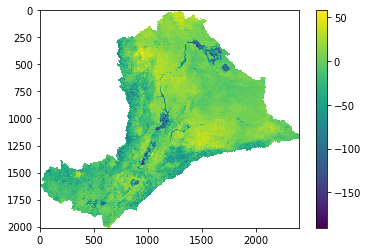

In [16]:
P=OpenAsArray(P_fh,nan_values=True)
ET=OpenAsArray(ET_fh,nan_values=True)
P_ET=P-ET
plt.imshow(P_ET)
plt.colorbar()
plt.show()

<div dir="rtl">
يمكننا استخدام حلقة for-loop لحساب خرائط P-ET لشهر عام 2009. سيتم حفظ ملفات الإخراج في المجلد P-ET_M (data/P-ET_M)    
</div>

[P-ET_M](data/P-ET_M)

In [17]:
output_folder=r'.\data\P-ET_M'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for date in dates:
    print(date)
    P_fh=P_path.format(str(date.year)[2:],date.month) #format filename باستخدام التاريخ المحدد
    ET_fh=ET_path.format(str(date.year)[2:],date.month) #format filename باستخدام التاريخ المحدد
    driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(P_fh)
    P=OpenAsArray(P_fh,nan_values=True)
    ET=OpenAsArray(ET_fh,nan_values=True)
    P_ET=P-ET
    filename='P-ET_{:2}{:02d}M.tif'.format(str(date.year)[2:],date.month)
    output_fh=os.path.join(output_folder,filename)
    print(output_fh)
    CreateGeoTiff(output_fh, P_ET, driver, NDV, xsize, ysize, GeoT, Projection)

2009-01-31 00:00:00
.\data\P-ET_M\P-ET_0901M.tif
2009-02-28 00:00:00
.\data\P-ET_M\P-ET_0902M.tif
2009-03-31 00:00:00
.\data\P-ET_M\P-ET_0903M.tif
2009-04-30 00:00:00
.\data\P-ET_M\P-ET_0904M.tif
2009-05-31 00:00:00
.\data\P-ET_M\P-ET_0905M.tif
2009-06-30 00:00:00
.\data\P-ET_M\P-ET_0906M.tif
2009-07-31 00:00:00
.\data\P-ET_M\P-ET_0907M.tif
2009-08-31 00:00:00
.\data\P-ET_M\P-ET_0908M.tif
2009-09-30 00:00:00
.\data\P-ET_M\P-ET_0909M.tif
2009-10-31 00:00:00
.\data\P-ET_M\P-ET_0910M.tif
2009-11-30 00:00:00
.\data\P-ET_M\P-ET_0911M.tif
2009-12-31 00:00:00
.\data\P-ET_M\P-ET_0912M.tif
2010-01-31 00:00:00
.\data\P-ET_M\P-ET_1001M.tif
2010-02-28 00:00:00
.\data\P-ET_M\P-ET_1002M.tif
2010-03-31 00:00:00
.\data\P-ET_M\P-ET_1003M.tif
2010-04-30 00:00:00
.\data\P-ET_M\P-ET_1004M.tif
2010-05-31 00:00:00
.\data\P-ET_M\P-ET_1005M.tif
2010-06-30 00:00:00
.\data\P-ET_M\P-ET_1006M.tif
2010-07-31 00:00:00
.\data\P-ET_M\P-ET_1007M.tif
2010-08-31 00:00:00
.\data\P-ET_M\P-ET_1008M.tif
2010-09-30 00:00:00


<div dir="rtl">

## التمرين 1    
    
</div>

<div dir="rtl">
اتبع مثال كيفية حساب المتوسط الشهري لهطول الأمطار في الأمثلة ، وحساب ورسم P-ET شهريًا لعام 2009 و 2010 في حوض Awash    
</div>

In [18]:
'''اكتب الرمز الخاص بك هنا'''

'Write your code here'

## 4. Land-use analysis

<div dir="rtl">
4. تحليل استخدامات الأراضي
</div>

<div dir="rtl">

### مثال:
    
</div>

<div dir="rtl">
سنقوم أولاً بقص البيانات النقطية WaPOR LCC التي تم تنزيلها من 3 بيانات WaPOR للتنزيل المجمع (3_Bulk_download_WaPOR_data.ipynb) ثم نحصل على قائمة فئات الغطاء الأرضي الفريدة من بيانات تصنيف الغطاء الأرضي WaPOR.    
</div>

[3 Bulk download WaPOR data](3_Bulk_download_WaPOR_data.ipynb)

In [20]:
shp_fh=r".\data\Awash_shapefile.shp"
LCC_folder=r'.\data\WAPOR.v2_yearly_L1_LCC_A'
LCC_fhs=sorted(glob.glob(os.path.join(LCC_folder,'*.tif'))) # الحصول على قائمة LCC النقطية
output_folder=r'.\data\WAPOR.v2_yearly_L1_LCC_A_clipped' #مجلد LCC جديد
if not os.path.exists(output_folder):
    os.makedirs(output_folder) # إنشاء مجلد P جديد
LCC_fhs=CliptoShp(LCC_fhs,output_folder,shp_fh) # قص جميع البيانات النقطية LCC لملف الشكل

<div dir="rtl">
سنفتح خريطة 1 LCC كمصفوفة NumPy للحصول على القيم الفريدة في الخريطة. هذه هي رموز تصنيف الغطاء الأرضي. للحصول على وصف أكواد LCC هذه ، راجع البيانات الوصفية لتصنيف الغطاء الأرضي على كتالوج WaPOR https://wapor.apps.fao.org/catalog/WAPOR_2/1/L1_LCC_A
</div>

| الشفرة        | اسم          | 
| :---------: |:-------------:| 
| 20 | ارض شجيرات      | 
| 30      |  مرج، مرعى، أرض معشوشبة      | 
| 41      | الأراضي الزراعية البعلية     | 
| 42      | الأراضي الزراعية أو المروية أو الخاضعة لإدارة المياه  |
| 43      | المحاصيل ، البور |   
| 50 | بناء      |  
| 60 | الغطاء النباتي العاري / المتناثر  | 
| 80 | اجسام مائية      | 
| 112 | غطاء شجري: مغلق ، دائم الخضرة عريضة   | 
| 114 | غطاء شجري: مغلق ، نفضي عريض الأوراق | 
| 116 | غطاء شجري: مغلق ، نوع غير معروف | 
| 124 | غطاء شجري: مفتوح ، نفضي عريض الأوراق | 
| 126 | غطاء شجري: مفتوح ، نوع غير معروف | 

In [21]:
LCC_fh=r".\data\WAPOR.v2_yearly_L1_LCC_A_clipped\L1_LCC_09.tif"
LCC=OpenAsArray(LCC_fh,nan_values=True)
LCC_values=np.unique(LCC[~np.isnan(LCC)])
LCC_codes=list(LCC_values)
print(LCC_codes)

[20.0, 30.0, 41.0, 42.0, 43.0, 50.0, 60.0, 80.0, 90.0, 112.0, 114.0, 116.0, 124.0, 126.0]


<div dir="rtl">
لحساب متوسط ET لكل غطاء أرضي ، يمكننا إخفاء خريطة ET حيث قيم خريطة LCC تساوي كل رمز LCC ، ثم حساب np.nanmean للمصفوفة المقنعة. على سبيل المثال ، للحصول على قيمة ET للأجسام المائية (رمز LCC هو 80) ، يمكننا استخدام الخطوات أدناه    
</div>

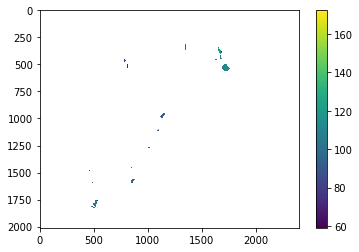

In [22]:
code=80 #اجسام مائية

mask=np.where(LCC==code,0,1)
in_fh=r".\data\WAPOR.v2_monthly_L1_AETI_M_clipped\L1_AETI_0901M.tif"
var=OpenAsArray(in_fh,nan_values=True)

import numpy.ma as ma # استيراد قناع وحدة مجموعة 
masked_map=ma.masked_array(var,mask)
plt.imshow(masked_map)
plt.colorbar()
plt.show()

<div dir="rtl">
بعد ذلك ، يمكننا حساب متوسط ET لفئة استخدام أراضي المسطحات المائية باستخدام المصفوفة المقنعة    
</div>

In [23]:
average=np.nanmean(masked_map)
print('Landuse class {0} Average: {1}'.format(code,average))

Landuse class 80 Average: 104.69696044921875


<div dir="rtl">
الآن ، يمكننا استخدام حلقة for-loop فوق أكواد LCC الفريدة لحساب متوسط قيمة ET لكل كود LCC.    
</div>

In [24]:
averages=[]
for code in LCC_codes:
    mask=np.where(LCC==code,0,1)
    masked_map=ma.masked_array(var,mask)
    averages.append(np.nanmean(masked_map))
LCC_avg=pd.DataFrame({'LCC code':LCC_codes,'Average Value': averages})
LCC_avg

LCC code  Average Value
0       20.0      37.537735
1       30.0      17.037479
2       41.0      47.709606
3       42.0      78.880722
4       43.0       6.646875
5       50.0      25.989452
6       60.0       8.477416
7       80.0     104.696960
8       90.0     100.415855
9      112.0     118.877800
10     114.0      93.828674
11     116.0     106.359238
12     124.0      71.121025
13     126.0      62.914829

<div dir="rtl">

## تمرين 2:
    
</div>

<div dir="rtl">
احسب جدولًا لمتوسط P-ET السنوي في حوض الأواش لجميع فئات استخدامات الأراضي لعام 2009.
</div>

<div dir="rtl">
تلميحات:
تتمثل الخطوة الأولى في جمع جميع البيانات النقطية P-ET الشهرية في عام 2009 لحساب P-ET السنوي لذلك العام.    
</div>

2009-01-31 00:00:00
2009-02-28 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-05-31 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-10-31 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00


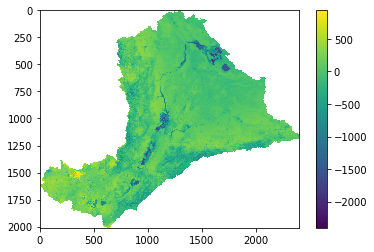

In [25]:
start_date='2009-01-01'
end_date='2009-12-31'
dates=pd.date_range(start_date,end_date,freq='M') # أنشئ نطاقًا زمنيًا من تاريخ البدء وتاريخ الانتهاء
PmET_path=r'.\data\P-ET_M\P-ET_{:2}{:02d}M.tif'
sameple_file=PmET_path.format(str(dates[0].year)[2:],dates[0].month)
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(sameple_file)
SumArray=np.zeros((ysize,xsize))
for date in dates:
    print(date)
    PmET_fh=PmET_path.format(str(date.year)[2:],date.month) # تنسيق اسم الملف باستخدام التاريخ المحدد
    SumArray+=OpenAsArray(PmET_fh,nan_values=True)
output_fh=os.path.join('.\data\P-ET_2009.tif')
CreateGeoTiff(output_fh, P_ET, driver, NDV, xsize, ysize, GeoT, Projection)
plt.imshow(SumArray)
plt.colorbar()
plt.show()

<div dir="rtl">
ثم ، باستخدام الخطوات المماثلة التي تم استخدامها لحساب متوسط ET لكل فئة غطاء أرضي لحساب P-ET لكل فئة غطاء أرضي.
</div>
<div dir="rtl">    
قارن التبخر في الأصناف الرئيسية: الغابات ، الشجيرات ، الأراضي العشبية ، المسطحات المائية ، الأراضي العارية ، المحاصيل البعلية ، المحاصيل المروية.    
</div>

In [26]:
'''اكتب الكود هنا'''

'Write your code here'